# Project 2
by: Alyssa Stover, Sophia Skowronski, Ying Hua

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os,random, math, psutil, pickle 

## Read in Data

In [2]:
# read in train datasets
train_df = pd.read_csv('train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
building_df = pd.read_csv('building_metadata.csv')
weather_train_df = pd.read_csv('weather_train.csv')

# read in test datasets
test_df = pd.read_csv ('test.csv')
weather_test_df = pd.read_csv ('weather_test.csv')

In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_df = reduce_mem_usage(building_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


## Initial Look at Data

In [5]:
building_df.shape
building_df.columns.values
building_df.head(5)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [6]:
train_df.shape
train_df.columns.values
train_df.head(5)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [7]:
weather_train_df.shape
weather_train_df.columns.values
weather_train_df.head(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


## Exploratory Data Analysis

### Taking a look at the explanatory variable

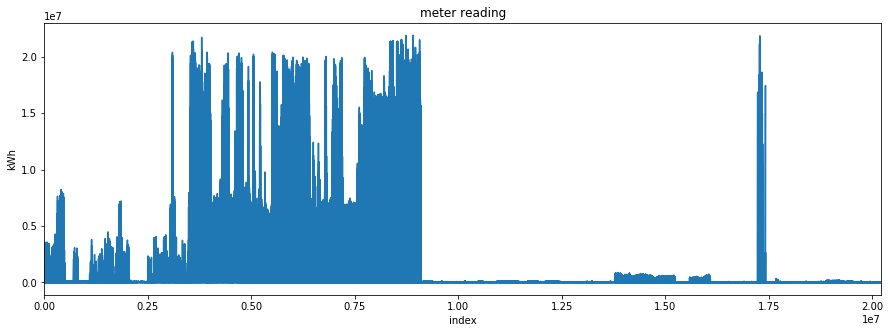

In [8]:
plt.figure(figsize = (15,5))
plt.title('meter reading')
plt.xlabel('index')
plt. ylabel('kWh')
train_df['meter_reading'].plot()

### Taking a look at missing data

#### Training dataset:  Does 0 meter reading represent 0 energy used or missing data?

In [9]:
train = train_df.set_index(['timestamp'])
train.head(5)
print ('Number of buldings:', str(len(set(train['building_id']))))
print('% of meter reading that is 0:',\
     "{:.1%}".format(len(train[train['meter_reading']==0])\
          /len(train['meter_reading'])))

Number of buldings: 1449
% of meter reading that is 0: 9.3%


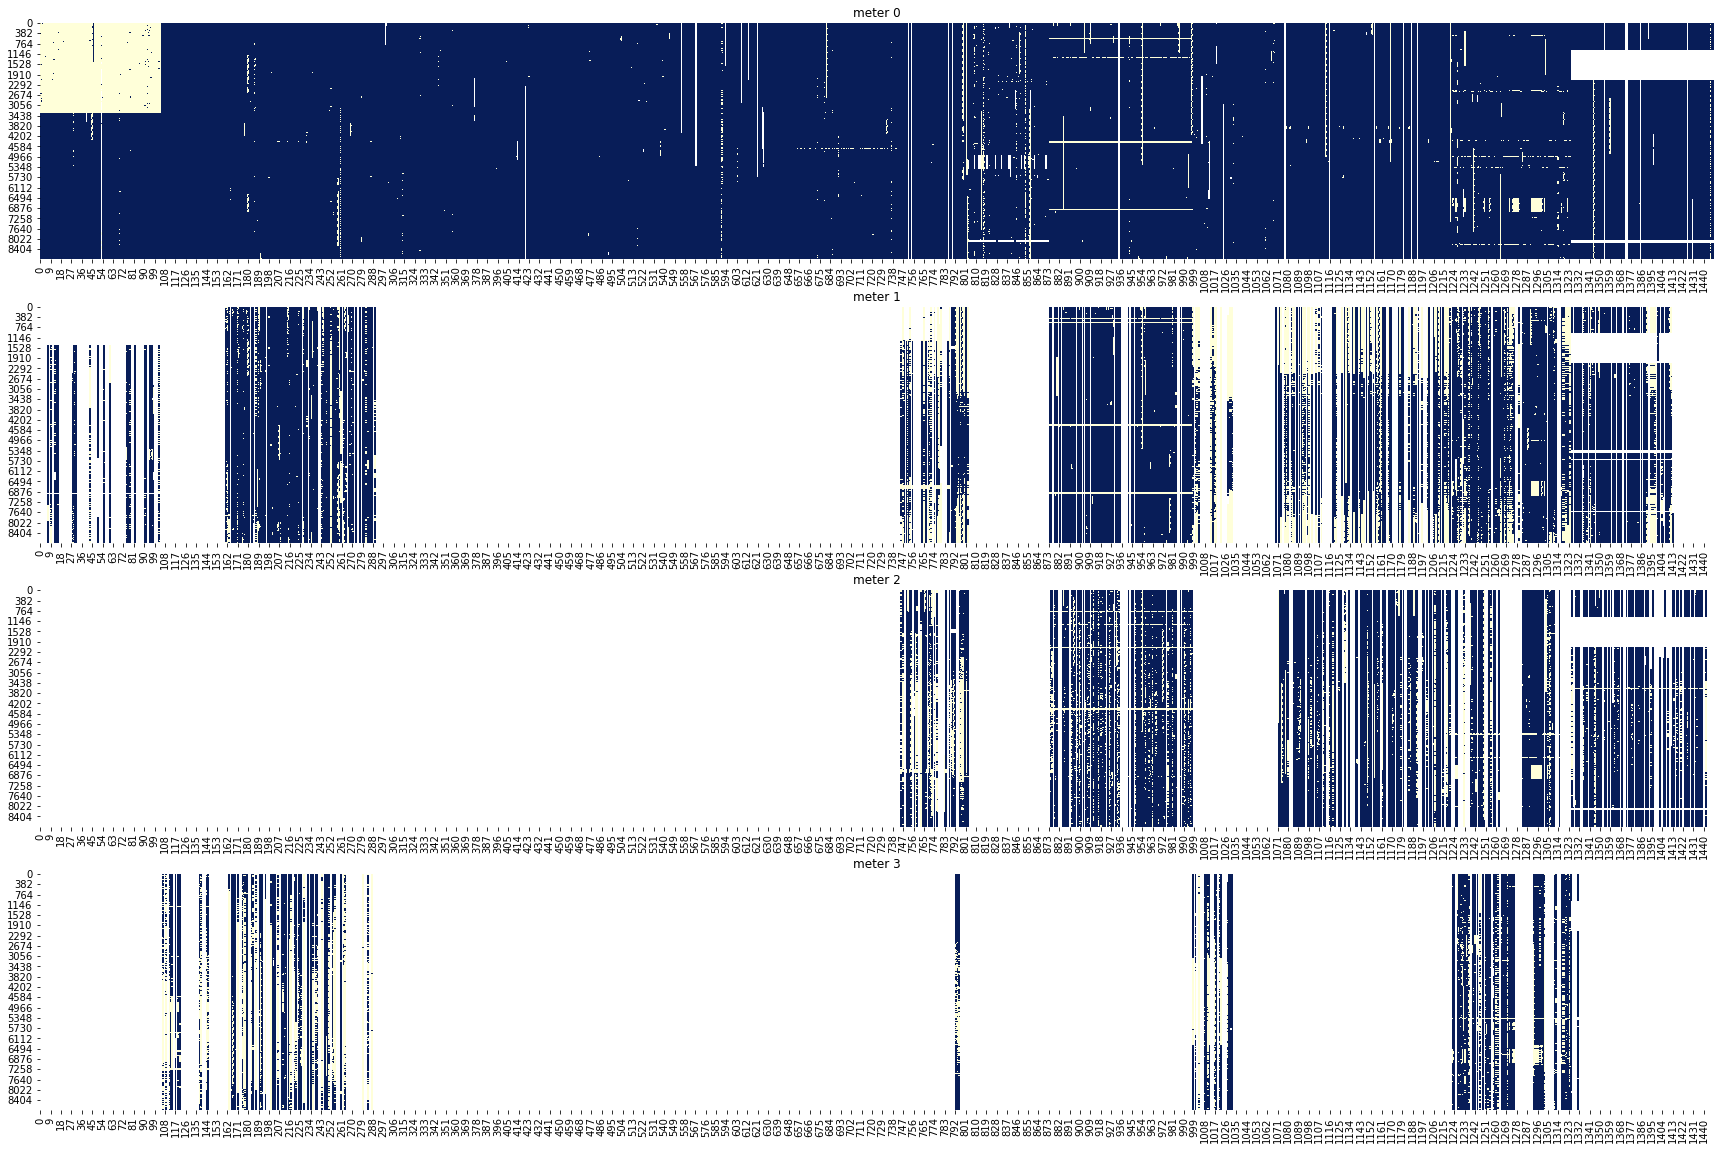

In [199]:
'''The codes below show a graph of 0 meter_reading values vs. non-zero
    values as we suspect some of these 0 values are actually missing
    data.  
    
    The codes below takes a long time to run. Use with caution.'''
f,a = plt.subplots(4,1,figsize=(30,20))
for meter in range(0,4):
    df = train[train.meter == meter].copy().reset_index()
    df['timestamp'] = df['timestamp'] - df['timestamp'].min() 
    df['timestamp'] = df['timestamp'].apply (lambda x: x.days*24+x.seconds//3600) #convert datetime to time index
    df['timestamp'] = df ['timestamp'].astype(int)
    missmap = np.empty((df.timestamp.max()+1, 1449)) # creating an empty array (building on x-axis, time on y)
    missmap.fill(np.nan)
    for i in df.values:
        if i[2] != meter:
            continue
        elif i[3] ==0:
            missmap[int(i[0]), int(i[1])] = 0 
        else:
            missmap[int(i[0]), int(i[1])] = 1
    a[meter].set_title(f'meter {meter:d}')
    sns.heatmap(missmap, cmap ='YlGnBu',ax=a[meter], cbar = False)

#### Missing data for dependent variables (i.e. building and weather data)

In [22]:
total = weather_train_df.isnull().sum()
percent = total/len(weather_train_df)*100
missing_weather_data  = pd.concat([total, percent], axis=1, \
                                  keys=['Total', 'Percent'])
missing_weather_data.style.set_properties(**{'text-align': 'left'})
missing_weather_data.sort_values (by = ['Percent'], ascending = False)



,Total,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
site_id,0,0.000000
timestamp,0,0.000000


In [24]:
total = building_df.isnull().sum()
percent = total/len(building_df)*100
missing_building_data  = pd.concat([total, percent], axis=1, \
                                  keys=['Total', 'Percent'])
missing_building_data.style.set_properties(**{'text-align': 'left'})
missing_building_data.sort_values (by = ['Percent'], ascending = False)

,Total,Percent
floor_count,1094,75.500345
year_built,774,53.416149
site_id,0,0.000000
building_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000


In [204]:
len(weather_train_df)

139773

In [205]:
weather_train_df.shape

(139773, 9)